Introduction
In this tutorial, we demonstrate how to use PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) to analyze a 31,000 cell 27-day time course of embryoid body (EB) differentiation. You can run and edit this notebook at https://colab.research.google.com/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb. Running the tutorial should take approximately 15 minutes excluding the t-SNE comparison, or 25 minutes including the comparison.

We review the following steps:

1. Loading 10X data
2. Preprocessing: Filtering, Normalizing, and Transforming
3. Embedding Data Using PHATE

Time course of human embryoid body differentation
Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS, 45 which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse

In [40]:

import scprep

ModuleNotFoundError: No module named 'scprep'

In [35]:
!which python


/usr/local/bin/python


In [1]:
pip list

Package                Version
---------------------- -----------------------
absl-py                0.10.0
anndata                0.7.5
argon2-cffi            20.1.0
astor                  0.8.1
astunparse             1.6.3
attrs                  20.1.0
backcall               0.2.0
biopython              1.78
bleach                 3.1.5
boto3                  1.16.10
botocore               1.19.10
cachetools             4.1.1
certifi                2020.6.20
cffi                   1.14.2
chainer                7.7.0
chardet                3.0.4
click                  7.1.2
cloudpickle            1.3.0
cntk-gpu               2.7
conda                  4.3.16
cupy                   7.8.0
cycler                 0.10.0
Cython                 0.29.21
decorator              4.4.2
defusedxml             0.6.0
Deprecated             1.2.10
dm-sonnet              2.0.0
dm-tree                0.1.5
entrypoints            0.3
enum34                 1.1.10
fastrlock              0.5
filelock    

In [33]:
!echo $PATH
!export PATH=$PATH:/usr/local/bin/python

/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


In [32]:
!/usr/local/bin/python -m pip install scprep

In [37]:
import sys
print(sys.executable)
print(sys.path)
print(sys.version_info)

/usr/local/bin/python
['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/pygpu-0.7.6-py3.6-linux-x86_64.egg', '/usr/local/lib/python3.6/dist-packages/Mako-1.1.3-py3.6.egg', '/usr/local/lib/python3.6/dist-packages/tape_proteins-0.4-py3.6.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [4]:
import os
import scprep
download_path = "/data/tapedir/notebooks/HPF_Project"
print(download_path)

/data/tapedir/notebooks/HPF_Project


In [6]:
if not os.path.isdir(os.path.join(download_path, "scRNAseq", "T0_1A")):
    # need to download the data
    scprep.io.download.download_and_extract_zip(
        "https://data.mendeley.com/public-files/datasets/v6n743h5ng/files/b1865840-e8df-4381-8866-b04d57309e1d/file_downloaded",
        download_path)

In [7]:
import pandas as pd
import numpy as np
import phate
import scprep

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

In [8]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/scprep-1.0.10-py3.6.egg/scprep/plot/histogram.py:156: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

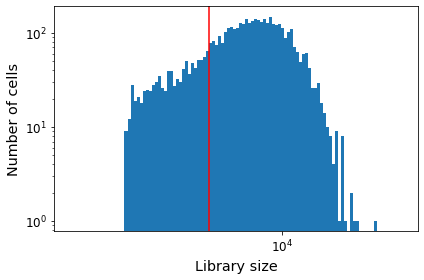

In [9]:
scprep.plot.plot_library_size(T1, percentile=20)

In [10]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

In [11]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),...,ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

In [13]:
EBT_counts2 = EBT_counts.copy()

In [14]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

<AxesSubplot:xlabel='Gene expression', ylabel='Number of cells'>

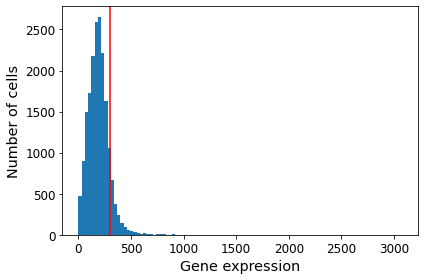

In [15]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

In [16]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

In [17]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [18]:
phate_operator = phate.PHATE(n_jobs=-2)

Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 51.58 seconds.
    Calculating KNN search...
    Calculated KNN search in 19.62 seconds.
    Calculating affinities...
    Calculated affinities in 1.82 seconds.
  Calculated graph and diffusion operator in 74.73 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 12.46 seconds.
    Calculating KMeans...
    Calculated KMeans in 192.60 seconds.
  Calculated landmark operator in 206.87 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 54.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.44 seconds.
Calculated PHATE in 346.11 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

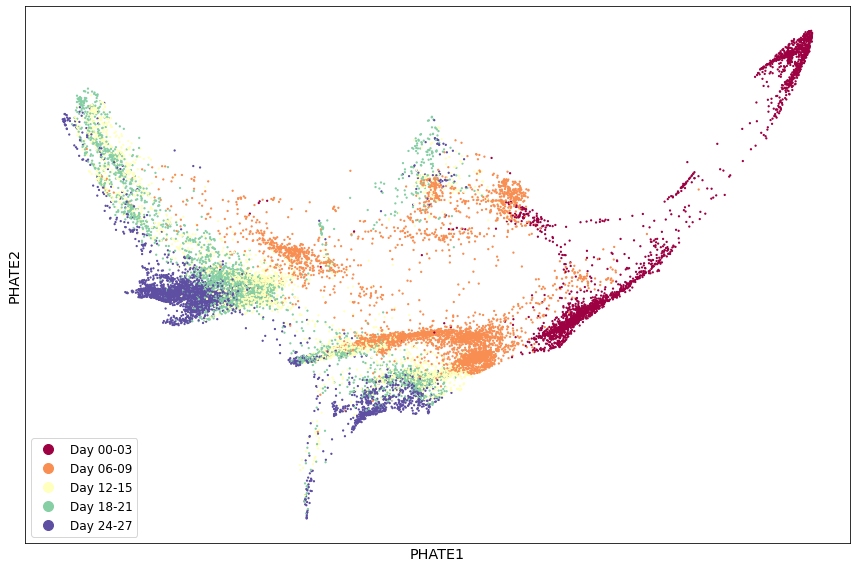

In [19]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

Calculating metric MDS...
Calculated metric MDS in 35.34 seconds.


<Axes3DSubplot:xlabel='PHATE1', ylabel='PHATE2'>

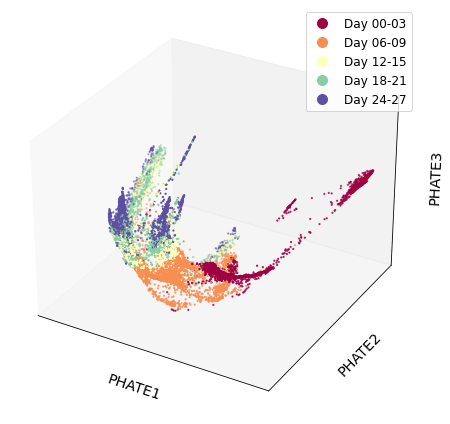

In [20]:
phate_operator.set_params(n_components=3)
Y_phate_3d = phate_operator.transform()
scprep.plot.scatter3d(Y_phate_3d, c=sample_labels, figsize=(8,6), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [21]:
import sklearn.decomposition # PCA
import sklearn.manifold # t-SNE
import time

start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
Y_pca = pca_operator.fit_transform(np.array(EBT_counts))
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=100)
tsne_operator = sklearn.manifold.TSNE(n_components=2)
Y_tsne = tsne_operator.fit_transform(pca_operator.fit_transform(np.array(EBT_counts)))
end = time.time()
print("Embedded t-SNE in {:.2f} seconds.".format(end-start))

Embedded PCA in 8.16 seconds.
Embedded t-SNE in 588.23 seconds.


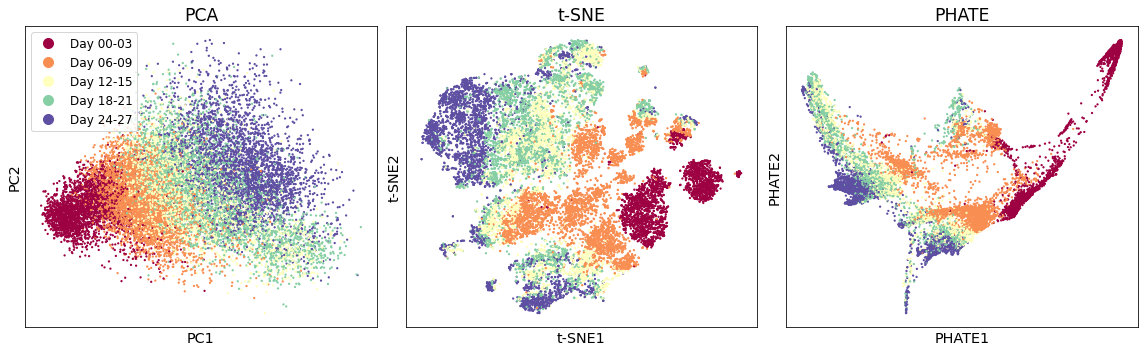

In [22]:
# plot everything
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))

#plotting PCA
scprep.plot.scatter2d(Y_pca, label_prefix="PC", title="PCA",
                      c=sample_labels, ticks=False, cmap='Spectral', ax=ax1)

#plotting tSNE
scprep.plot.scatter2d(Y_tsne, label_prefix="t-SNE", title="t-SNE", legend=False,
                      c=sample_labels, ticks=False, cmap='Spectral', ax=ax2)

#plotting PHATE
scprep.plot.scatter2d(Y_phate, label_prefix="PHATE", title="PHATE", legend=False,
                      c=sample_labels, ticks=False, cmap='Spectral', ax=ax3)

plt.tight_layout()
plt.show()